# EDA

### EDA란?

* 목표를 갖고 데이터셋에 대하여 분석하고 이해해, 인공지능 학습에 용이하도록 정돈하는 과정
* 인공지능을 최적으로 학습시키기 위해 필수적이다.

## EDA의 필요성

<div>
    <img src="https://i.ibb.co/cLCxNTk/image.png" width="550"/>
</div>

음식을 예시로
* 음식을 맛있게 만들기 위해 조리과정도 물론 중요
* 하지만 요리에 맞는 재료를 선별 및 손질하는 것도 필요
* 맛있는 음식을 성공적인 인공지능이라고 한다면, 재료를 선별, 손질하는 일이 EDA

예를 들어 성인의 신체정보에 따른 골격근량을 예측하는 AI를 만들려고 하자
* 학습 feature로 목표와 연관이 적은 feature를 사용하면 학습 효율이 낮아짐
    * 치아의 개수, 시력
* feature값이 잘못 기재되거나, 아예 유실되었을 경우 학습 정확도에 악영향을 미침
    * 성인 남성 A의 몸무게가 72kg->7.2kg으로 기재

효과적인 EDA를 통해 이러한 문제를 회피하고, 유효한 값이 있는 feature를 추출해 학습시켜야 성공적인 학습이 가능하다.

## EDA 방식

<div>
    <img src="https://i.ibb.co/55wGHcc/EDA.jpg" width="500"/>
</div>

EDA는 크게
* 데이터 분포 확인
* 연관성 검사
* 관련성 적은 feature 탈락
* 이상치 및 결측값 수정

으로 이루어진다. 각각의 방법을 직접 실습을 수행하며 진행해보자

# 실습

## Kaggle Dataset 다운받기

데이터셋을 다운 받기 위해 kaggle api를 설치할 것이다. 밑에 코드를 실행하자. kaggle을 다운 받고 나면 OSError가 나오지만 아직 kaggle API Token을 받지 않아서 그런 것이니 걱정하지 말자.

In [3]:
!pip install kaggle
print("-----------------------------------------------")
!pip show kaggle
print("-----------------------------------------------")
!kaggle config view

-----------------------------------------------
Name: kaggle
Version: 1.5.12
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: c:\programdata\anaconda3\lib\site-packages
Requires: certifi, python-dateutil, python-slugify, requests, six, tqdm, urllib3
Required-by: 
-----------------------------------------------
Configuration values from C:\Users\Unity\.kaggle
- username: newxxson
- path: None
- proxy: None
- competition: None


이제 캐글에 로그인(회원가입)을 하고 API 토큰을 받도록 하자.

Account -> API -> Create New API Token (안되면 질문해주세용)

<div>
    <img src="https://i.ibb.co/xGQ0nsQ/api-token.png" width="700"/>
</div>

이제 받은 kaggle.json을 C:\Users/UserName/.kaggle에 집어넣고 다시 config를 해보자

In [16]:
!kaggle config view

Configuration values from C:\Users\Unity\.kaggle
- username: newxxson
- path: None
- proxy: None
- competition: None


제대로 작동이 되는 것을 확인했으므로 이제 데이터셋을 다운 받아 본격적으로 분석을 시작하자.

In [2]:
!kaggle datasets download -d CooperUnion/cardataset


  0%|          | 0.00/103k [00:00<?, ?B/s]
100%|##########| 103k/103k [00:00<00:00, 3.73MB/s]


In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

import zipfile

In [63]:
directory = "C:/Users/Unity/" # C:/Users/UserName/

data_zip = zipfile.ZipFile(directory + 'cardataset.zip')
data_zip.extractall(directory)
data_zip.close()

data = pd.read_csv(directory+'data.csv')

data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


추가 Info
* Year: 출시연도
* Engine Fuel Type: 
    * unleaded = 무연휘발유, 종류 = 고급(권장/필수) / 일반)
    * flex-fuel = 이중연료. 괄호 안에 명시된 두 연료 전부 사용 가능
        * E85는 에탄올 85%, 가솔린15%
* Transmission Type: 기어 변속 종류, 여기서 Direct drive는 기어가 없이 모터에 바로 연결된 것을 뜻한다.
    * Unknown은 결측값이다.
* Driven_Wheels: 동력이 전달되는 바퀴의 수
    * all wheel drive는 주로 SUV가 사용하는 방식으로 4개 바퀴에 각각 독립적으로 동력을 전달한다.
    * four wheel drive는 주로 트럭이 사용하며, 4개 바퀴에 균일하게 동력을 전달한다.
* Vehicle Style: 차량 종류로 사진으로 보는 게 나아서 검색 추천
* highway, city mpg: Mile per Gallon -> 연비
<br>

* MSRP : 소비자 권장 가격($) = 우리의 인공지능 예측 목표

전세계의 각종 차회사들의 제품들의 정보를 담고 있는 데이터셋으로 우리는 이것을 이용해서 자동자의 정보가 입력되면 가격을 예측하는 인공지능을 만들 것이다.

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

info를 통해서 각 column들의 이름과 결측값을 제외한 데이터 수(Non-Null)를 알 수 있다.<br>더 검사를 해봐야겠지만 9번 Market Category에 결측값이 상당한 것을 확인할 수 있다.


## Checking for missing values

중복된 값들을 먼저 확인하고 지우자.


In [65]:
print("Number of duplicates: ", data.duplicated().sum())
data = data.drop_duplicates()

Number of duplicates:  715


In [66]:
print("Number of missing values(null): ", data.isnull().sum(), sep='\n')

Number of missing values(null): 
Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3376
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64


가장 많은 결측값을 가진 Market Category가 어떤 자료인지 살펴보자

In [67]:
market_category = data[['Make','Model', 'Market Category']]
market_category[:100:5]

,Make,Model,Market Category
0,BMW,1 Series M,"Factory Tuner,Luxury,High-Performance"
5,BMW,1 Series,"Luxury,Performance"
10,BMW,1 Series,"Luxury,High-Performance"
16,BMW,1 Series,"Luxury,High-Performance"
23,Audi,100,Luxury
30,Audi,100,Luxury
35,Mercedes-Benz,190-Class,Luxury
40,Mercedes-Benz,190-Class,Luxury
45,BMW,2 Series,Luxury
50,BMW,2 Series,"Factory Tuner,Luxury,High-Performance"


In [68]:
print(market_category['Market Category'].values.size)
print(market_category['Market Category'].values)

11199
['Factory Tuner,Luxury,High-Performance' 'Luxury,Performance'
 'Luxury,High-Performance' ... 'Crossover,Hatchback,Luxury'
 'Crossover,Hatchback,Luxury' 'Luxury']


시장에서 홍보하는 키워드인 것으로 판단되는데, NaN(결측값)이 많고 키워드의 종류도 너무 많아 학습에 용이하지 않으므로 해당 feature는 삭제하도록 하자.

In [69]:
data.drop('Market Category', axis = 1, inplace = True)

이제 NaN 값을 갖는 다른 feature들도 확인해보자.

In [70]:
null_data = data[data.isnull().any(axis=1)]
null_data

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
539,FIAT,500e,2015,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,108,122,819,31800
540,FIAT,500e,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,103,121,819,31800
541,FIAT,500e,2017,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,103,121,819,31800
1983,Chevrolet,Bolt EV,2017,electric,200.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,110,128,1385,40905
1984,Chevrolet,Bolt EV,2017,electric,200.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,110,128,1385,36620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853,Kia,Soul EV,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,Wagon,92,120,1720,31950
9854,Kia,Soul EV,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,Wagon,92,120,1720,35950
11321,Suzuki,Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,Midsize,Sedan,25,17,481,17199
11322,Suzuki,Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,Midsize,Sedan,25,17,481,20199


엔진 종류가 전기인 차들이 Engine HP가 Nan 인 것 같다 확인해보자 

In [71]:
HP_data = null_data[null_data['Engine HP'].isnull()]
HP_data

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
539,FIAT,500e,2015,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,108,122,819,31800
540,FIAT,500e,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,103,121,819,31800
541,FIAT,500e,2017,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,103,121,819,31800
2905,Lincoln,Continental,2017,premium unleaded (recommended),NaN,6.0,AUTOMATIC,all wheel drive,4.0,Large,Sedan,25,17,61,55915
2906,Lincoln,Continental,2017,premium unleaded (recommended),NaN,6.0,AUTOMATIC,front wheel drive,4.0,Large,Sedan,27,18,61,62915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9850,Kia,Soul EV,2015,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,Wagon,92,120,1720,35700
9851,Kia,Soul EV,2015,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,Wagon,92,120,1720,33700
9852,Kia,Soul EV,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,Wagon,92,120,1720,33950
9853,Kia,Soul EV,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,Wagon,92,120,1720,31950


In [72]:
HP_data['Engine Fuel Type'].value_counts()

electric                            44
regular unleaded                    14
flex-fuel (unleaded/natural gas)     6
premium unleaded (recommended)       4
diesel                               1
Name: Engine Fuel Type, dtype: int64

전기차 이외에도 결측값이 존재했으며,

In [73]:
data[data['Engine Fuel Type']=='electric'].head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
539,FIAT,500e,2015,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,108,122,819,31800
540,FIAT,500e,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,103,121,819,31800
541,FIAT,500e,2017,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,103,121,819,31800
1680,Mercedes-Benz,B-Class Electric Drive,2015,electric,177.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,82,85,617,41450
1681,Mercedes-Benz,B-Class Electric Drive,2016,electric,177.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,82,85,617,41450


모든 전기차가 HP가 NaN이었던 것도 아니어서 전기차만의 고유 특성이 아니었다.<br>
결국 결측값들에 대해서 수정을 해줘야하는데

이때, 이러한 결측치들을 해소하기 위해 여러가지 방법이 사용된다.
### 결측치 제거 방법

1. 완전 제거법: 위의 Market Category에 대해 시행한 것처럼 학습 데이터에서 제거하는 방법. 위처럼 feature 자체를 제거하거나, 결측값을 가진 샘플만 삭제할 수도 있음
<br>

2. 단일대체법: 데이터셋 내에서 일정한 과정을 통해 연산된 값으로 대체
    1. 평균 대체 : 간단하지만 해당 feature의 분산을 줄이고, 분석결과 편향이 생길 수 있음
    2. 회귀 대체 : 결측 샘플을 제외한 샘플들에게서 조건부 평균으로 결측을 대체. 평균 대체와 동일한 한계가 존재
    
    
3. 다중대체법: 3단계로 구성되는 결측치 보강으로
    1. Imputation Phase: 가능한 대체 값의 분포에서 추출된 서로 다른 값으로 결측치를 처리한 M개의 새로운 데이터셋을 만든다.
    2. Analysis Phase: 만들어진 각각의 데이터셋에 대해서 분석을 수행한다.
    3. Pooling Phase: 분석을 통해 얻은 모수(원본을 대표하는 값)의 추정량과 표본오차를 통합해 하나의 분석결과를 제시한다.


<div>
    <img src="https://i.ibb.co/HCwFqHd/image.png" width="500"/>
</div>

다중대체법이 가장 진화된 방법이지만, 지나치게 복잡하기 때문에 기법이 존재함만을 알고 이번 실습에서는 완전 제거법을 사용하도록 하자.

In [74]:
data.dropna(axis=0, how = 'any', inplace=True)
data.drop(data[data['Transmission Type']=='UNKNOWN'].index, axis='index', inplace = True)
print("Number of missing values(null): ", data.isnull().sum(), sep='\n')
print("Number of data : ", data.size)

Number of missing values(null): 
Make                 0
Model                0
Year                 0
Engine Fuel Type     0
Engine HP            0
Engine Cylinders     0
Transmission Type    0
Driven_Wheels        0
Number of Doors      0
Vehicle Size         0
Vehicle Style        0
highway MPG          0
city mpg             0
Popularity           0
MSRP                 0
dtype: int64
Number of data :  166275


## Handling Outliers

결측값에 대해서 처리를 해주었으니, 이제 이상치에 대해서 알아보자.


### 이상치란?
이상치란 '변수의 분포상 비정상적으로 극단적인 값을 가져 일반적인 범위를 벗어난 관측치'로 정의되는데, 쉽게 말해 우리의 예상을 뛰어넘는 값이 나왔을 때 이를 이상치라고 한다.
<br>
<br>
예를 들어, 성인 남성 몸무게에 대한 통계에서 몸무게 샘플 중 하나가 2000kg가 나왔거나 2kg이 나왔다면 이는 비정상적인 분포로 이상치일 확률이 높다.
<br>
<br>
이상치는 테이터 수집 중 실수, 오류로 인해 발생하거나 실제로 데이터가 특별한 경우 등에서 발생한다.

### 이상치의 기준은?
1. IQR을 이용하는 경우 : BoxPlot
<br>
어떤 분포에서 분포의 상위 25% ~75% 구간의 크기를 Interquartile Range(IQR)이라고 하며, 상위 25% 지점을 Q3, 상위 75%구간을 Q1이라 하면 이상치는 Q1 - 1.5IQR 미만와 Q3 + 1.5IQR 초과의 값들을 의미한다.
<br>
<br>
Boxplot이 이런 분포를 나타내는 방식으로, 이번 실습에서는 이 boxplot을 이용해서 이상치를 확인할 것이다

<div>
    <img src="https://i.ibb.co/Jyhnppv/iqr.png" width="550"/>
</div>

2. 표준편차를 이용하는 경우
<br>
데이터가 샘플의 양이 많아 정규분포와 유사한 분포를 가지면 표준화 과정을 거쳐 평균에서부터 3SD(표준편차) 이상의 거리를 가진 샘플에 대해 이상치라고 규정한다.

<div>
    <img src="https://i.ibb.co/TvC3ZBk/SD.png" width="500"/>
</div>

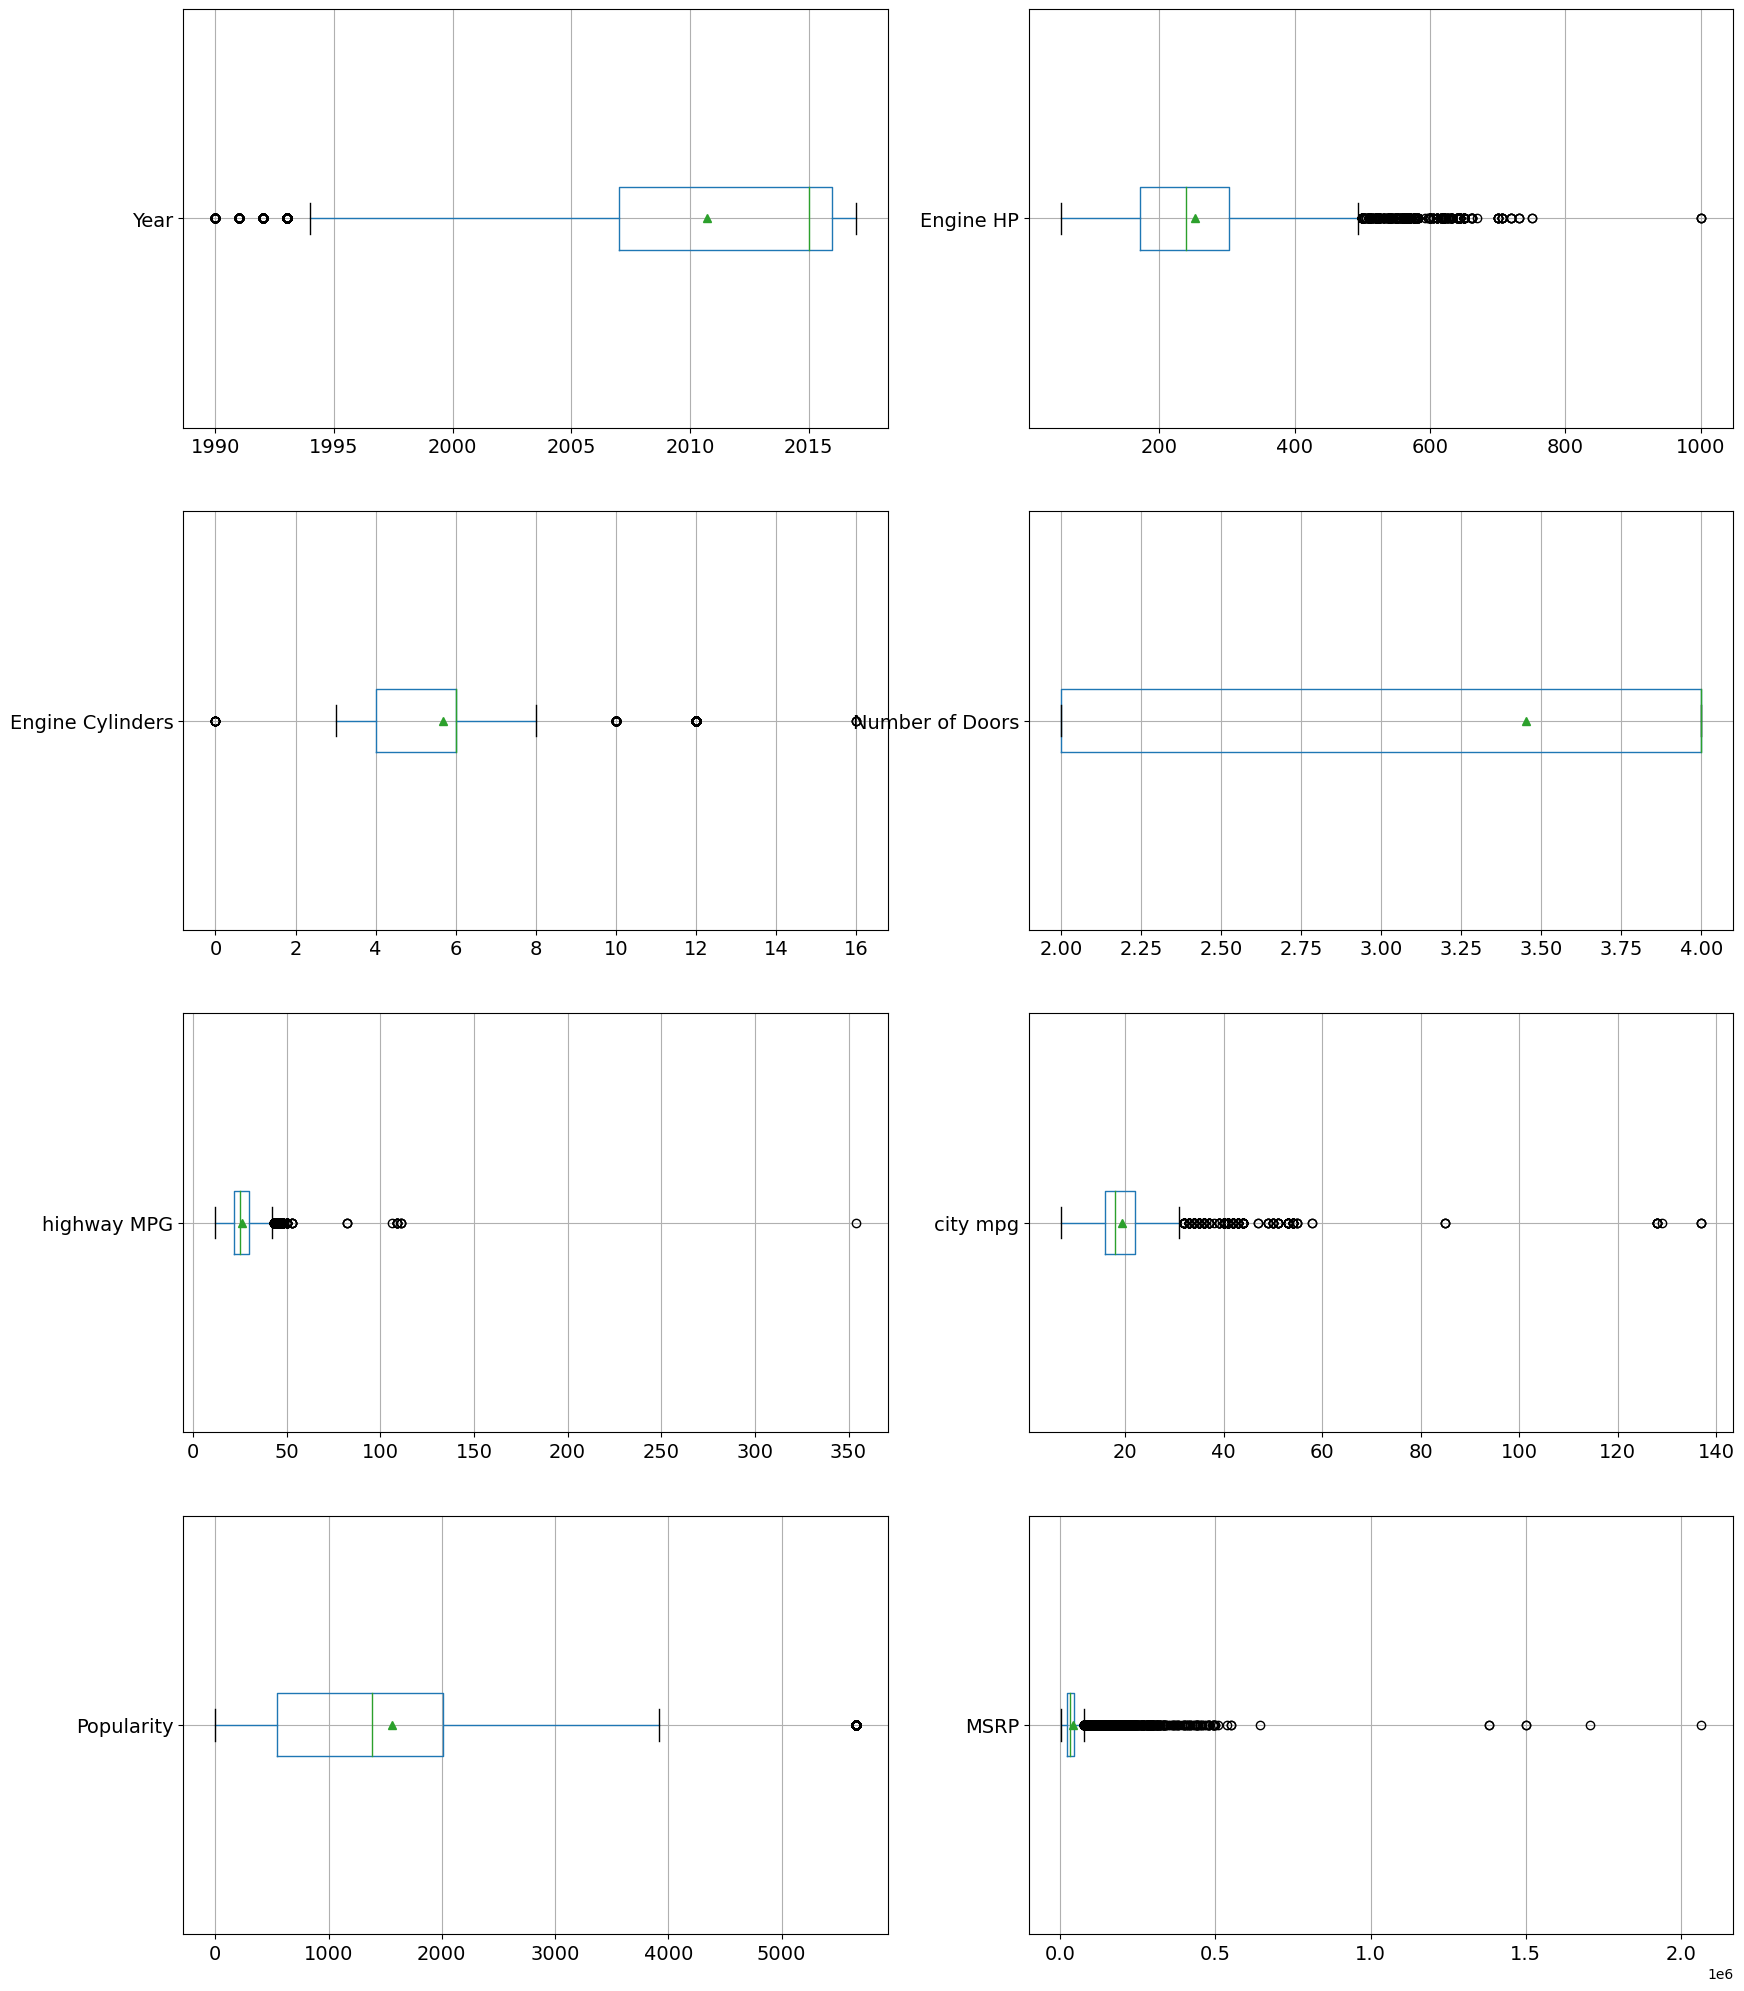

In [98]:
#numerical data extraction
num_col = data.select_dtypes(include=[np.number])

#boxplot visualization
fig , ax = plt.subplots(nrows=4, ncols=2)
fig.set_figheight(25)
fig.set_figwidth(20)
for index, key in enumerate(num_col):
    i, j = divmod(index, 2)
    data.boxplot(key, ax=ax[i, j], showmeans=True, vert=False, fontsize= 14)
    

Engine HP, MPG, MSRP에서 이상치가 많은 것을 확인할 수 있다. 각각 어떤 샘플인지 살펴보자

In [105]:
#Engine HP 에는 이상치의 값들이 전부 범위 이상으로 크다.
HP_qt1 = data['Engine HP'].quantile(0.25)
HP_qt3 = data['Engine HP'].quantile(0.75)
HP_iqr = HP_qt3 - HP_qt1


higher = HP_qt3 + (1.5*HP_iqr)

HP_data = data[data['Engine HP']>higher]

HP_data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
466,Ferrari,458 Italia,2013,premium unleaded (required),562.0,8.0,AUTOMATED_MANUAL,rear wheel drive,2.0,Compact,Convertible,17,13,2774,257412
467,Ferrari,458 Italia,2013,premium unleaded (required),562.0,8.0,AUTOMATED_MANUAL,rear wheel drive,2.0,Compact,Coupe,17,13,2774,233509
468,Ferrari,458 Italia,2014,premium unleaded (required),562.0,8.0,AUTOMATED_MANUAL,rear wheel drive,2.0,Compact,Coupe,17,13,2774,233509
469,Ferrari,458 Italia,2014,premium unleaded (required),597.0,8.0,AUTOMATED_MANUAL,rear wheel drive,2.0,Compact,Coupe,17,13,2774,288000
470,Ferrari,458 Italia,2014,premium unleaded (required),562.0,8.0,AUTOMATED_MANUAL,rear wheel drive,2.0,Compact,Convertible,17,13,2774,257412


MSRP가 상당히 높은 것을 확인할 수 있다. 연관성이 있는지 살펴보자

<AxesSubplot: xlabel='Engine HP', ylabel='MSRP'>

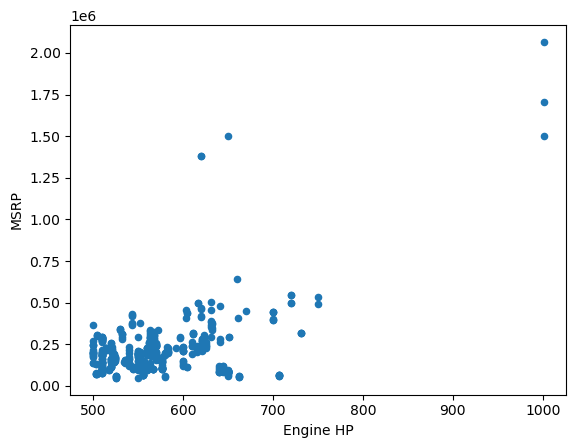

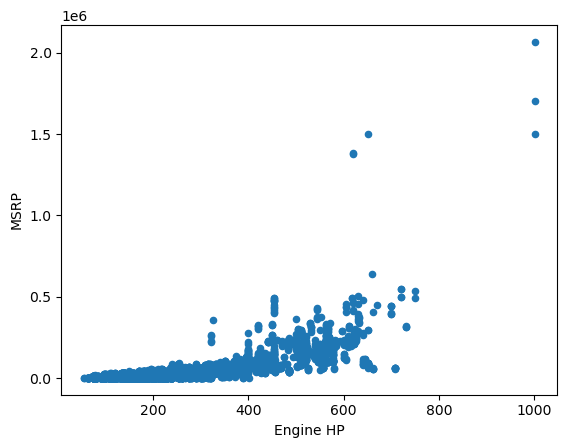

In [112]:
HP_data.plot.scatter(x='Engine HP', y='MSRP')
data.plot.scatter(x='Engine HP', y='MSRP')

어느정도는 연관성이 있다고 볼 수 있다. 이러한 이상치를 다루는 상황에서는 문제가 생길 수 있다.
1. 연관성이 있으므로 제거하지 않고 학습 데이터로 사용한다.
    > 이상치들은 기본적으로 그 수가 적어 분포에서의 비중이 적다. 하지만 비정상적인 값으로 인해 평균과 분산이 왜곡되는 등 큰 영향을 미칠 수 있다.
    <br>
    >통계를 통해 학습하는 함수형 회귀분석의 경우 인공지능의 성능 자체에 영향을 끼칠 수 있다.
<br>
<br>
    Ex) 회사원들의 연봉을 예측하는데 회사 임원과 사장, 회장의 연봉도 통계에 포함되는 경우 => 평균과 분산이 커져 통계에 영향을 미치고, 학습에도 영향을 미침
    
2. 분석에 영향이 가므로 제거한다.
    > 이상치 자체가 중요한 정보를 담고 있을 가능성이 있는데, 학습에 반영되지 않아 예측 정확도가 줄어들 수 있음
    <br>
    > 또한, 데이터 수집 과정에서 편향이 있었다면 이상치가 잘못 설정되었을 수도 있다.
    <br>
    <br>
    Ex)마력이 높을 수록 가격이 비선형적으로 높아지는데, 이상치를 제거하면 이 비선형성이 제대로 반영되지 않을 수 있다.
    

하지만 역시나 우리는 지금 간단한 실습을 하고 있는 것이므로 이상치는 전부 제거해주도록 하자.

In [113]:
drop_list = ['Engine HP', 'Engine Cylinders', 'highway MPG', 'city mpg', 'MSRP']

for column in drop_list:
    qt1 = data[column].quantile(0.25)
    qt3 = data[column].quantile(0.75)
    iqr = qt3 - qt1
    lower = qt1 - (1.5*iqr)
    higher = qt3 + (1.5*iqr)
    min_index = data[data[column]<lower].index
    max_index = data[data[column]>higher].index
    data.drop(min_index, inplace = True)
    data.drop(max_index, inplace = True)

data

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23,16,204,46120
11910,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23,16,204,56670
11911,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23,16,204,50620
11912,Acura,ZDX,2013,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23,16,204,50920


이상치들을 제거했으므로 다음 단계로 넘어가자.
## Dropping  irrelevant columns & Finding correlations

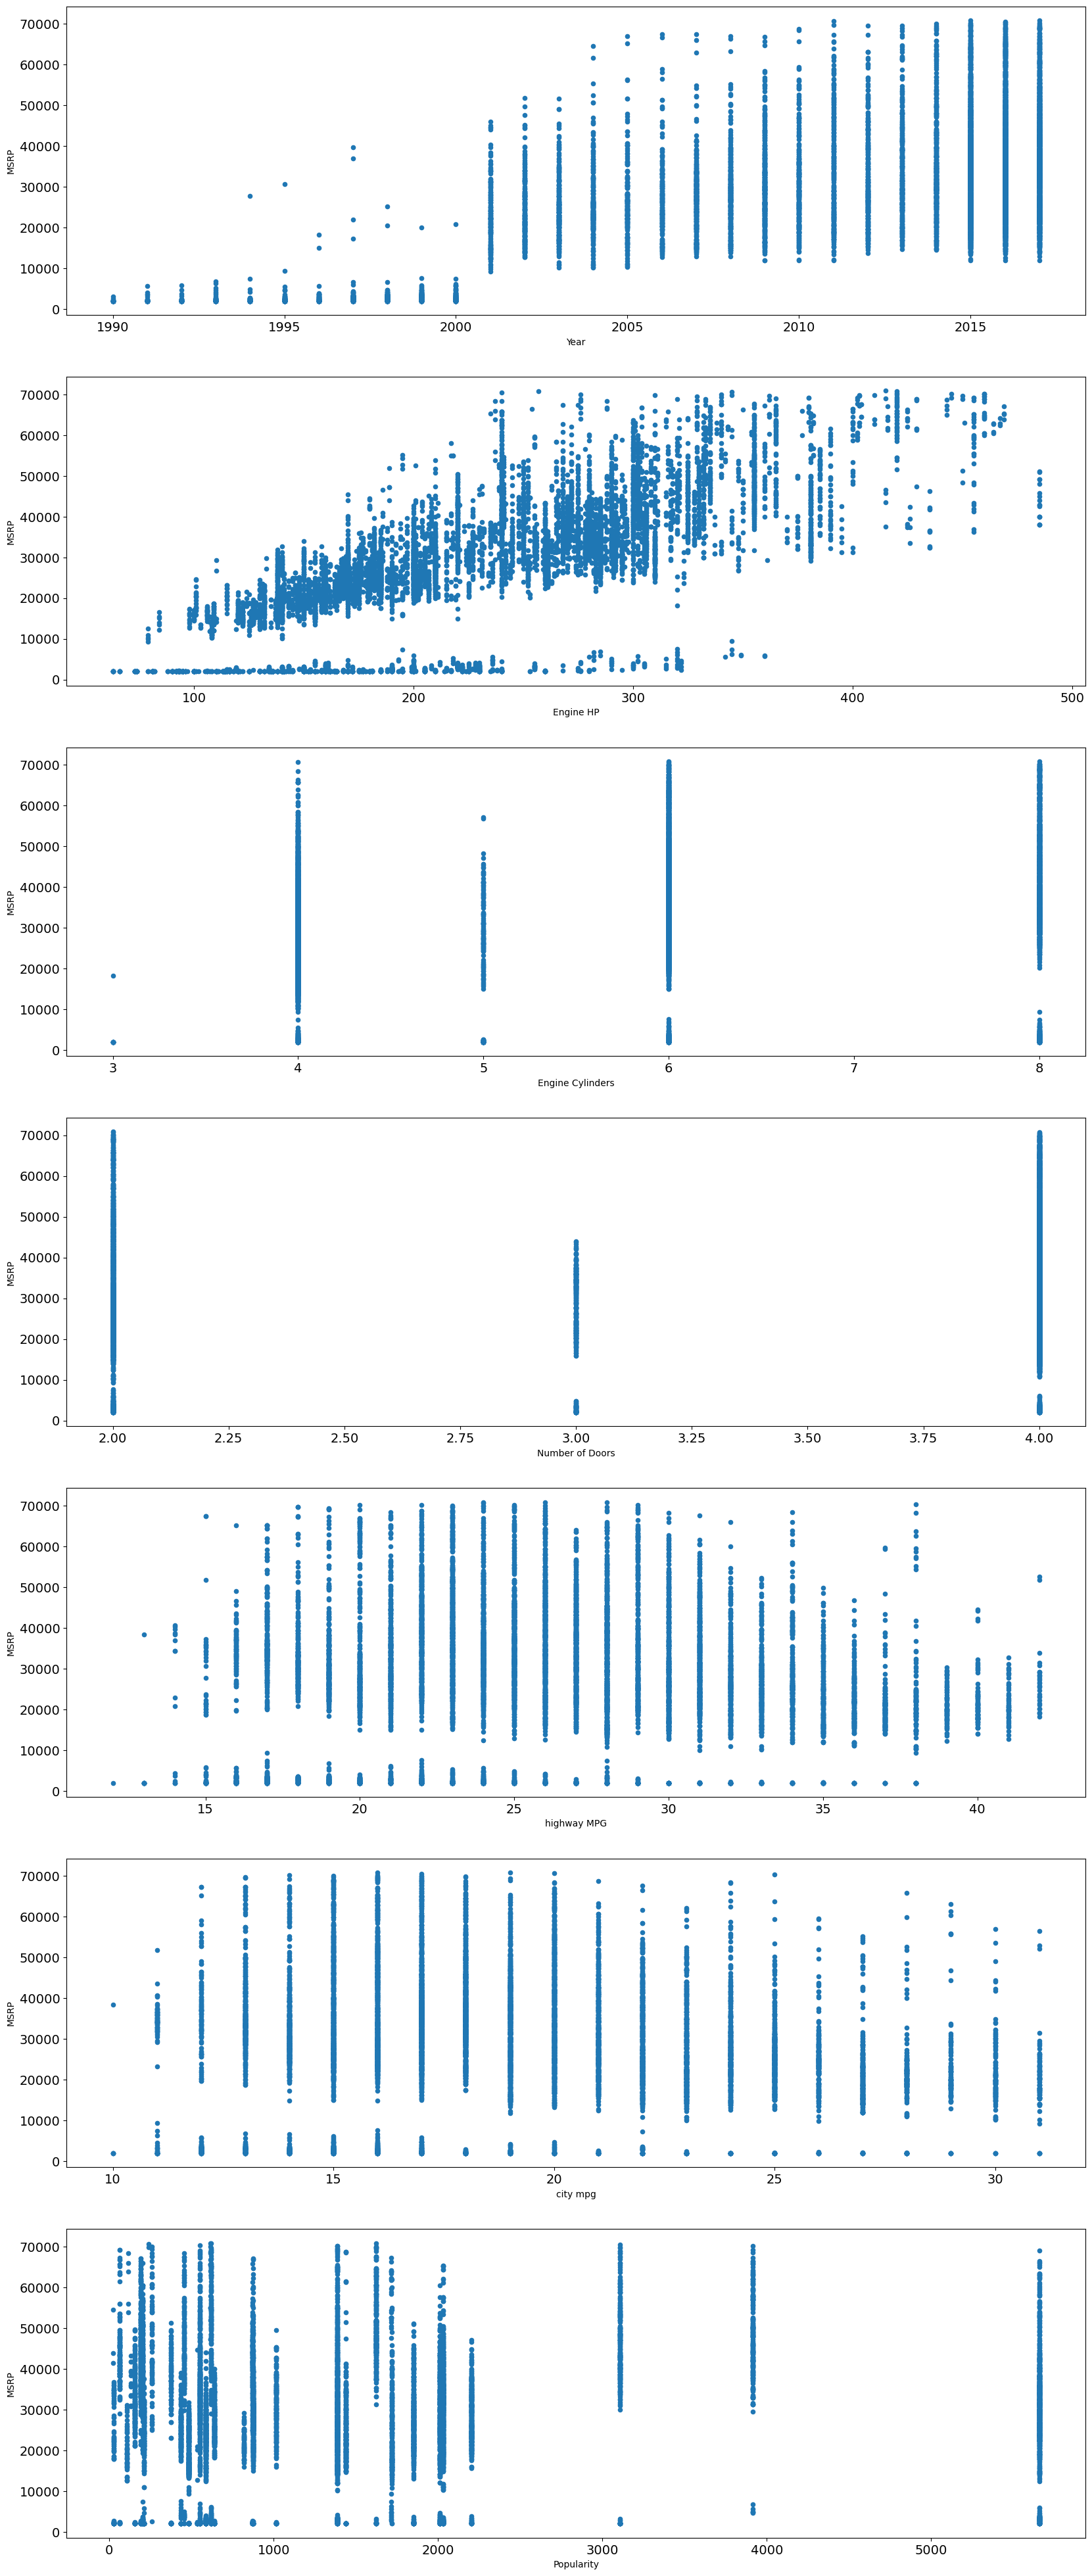

In [151]:
#numerical data extraction
num_col = data.select_dtypes(include=[np.number])
num_col.drop(labels='MSRP', axis=1, inplace = True)

#scatter visualization
fig , ax = plt.subplots(nrows=7, ncols=1)
fig.set_figheight(50)
fig.set_figwidth(20)
for index, key in enumerate(num_col.keys()):
    data.plot.scatter(x=key, y='MSRP', ax=ax[index], fontsize= 14)

위의 분포로 연도가 최근에 가까워질수록 가격이 올라갔다는 것을 알 수 있고, 2010년을 기점으로 가격이 크게 증가한 것을 알 수 있다. 가격이 올라간 이유에는 여러 요인이 있을 수 있다. 예를 들어 금융위기로 인한 인플레이션이 있었을 수도 있다.

<div>
    <img src="https://i.ibb.co/47rNxMw/economic-crisis.png" width="600"/>
</div>

엔진 마력 또한 증가할 수록 가격이 상승한다는 것을 확인할 수 있다.
<br>
차문의 개수가 3개이면 문의 개수가 2나 4일 때보다 가격이 낮을 확률이 높다
<br>
<br>
위 통계를 통해서 생산연도와 마력, 문의 개수는 가격과 연관성이 있다는 것을 확인할 수 있었다.

하지만 다른 feature들은 영향력을 육안으로 쉽게 확인할 수 없다. 그렇다면 가격과 연관성이 적은 feature들일까?
<br>
다른 feature들과 연관지어 분석해보자


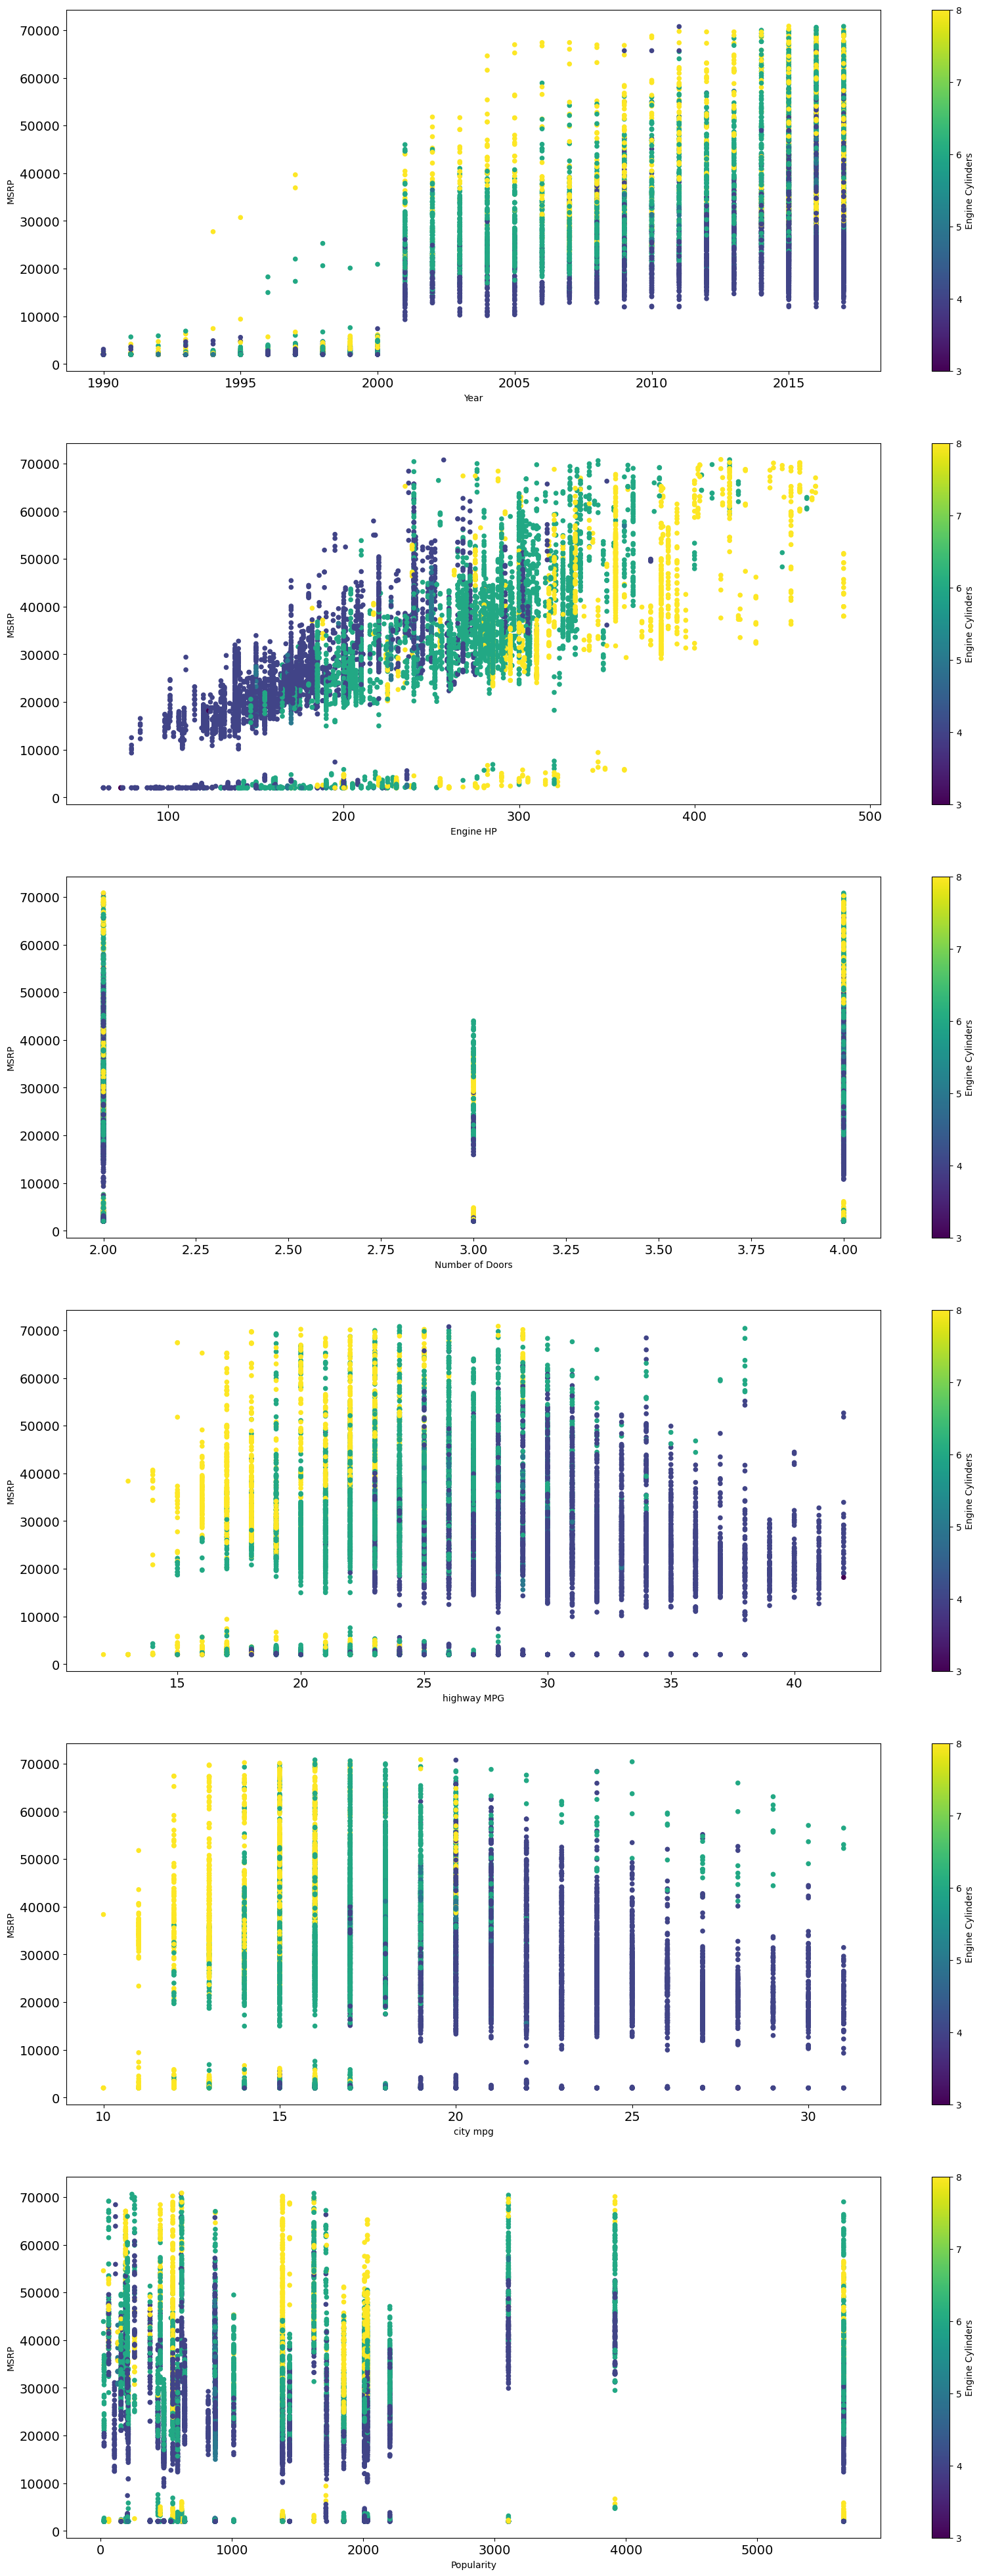

In [160]:
#numerical data extraction
num_col = data.select_dtypes(include=[np.number])
no_cy = num_col.drop(labels=['Engine Cylinders','MSRP'], axis=1, inplace = False)
#scatter visualization
fig , ax = plt.subplots(nrows=6, ncols=1)
fig.set_figheight(50)
fig.set_figwidth(20)
for index, key in enumerate(no_cy.keys()):
    data.plot.scatter(x=key, y='MSRP', c='Engine Cylinders', ax=ax[index], fontsize= 14)

1. 엔진 마력이 높을 수록 실린더의 개수가 많아지고, 가격이 올라간다.
2. 연비는 실린더가 많을수록 나빠진다.
3. 인기가 같다면 실린더의 수(엔진 마력)가 많다면 가격이 높다.

이 세가지를 새롭게 알 수 있었다.

<br>
<br>
이런 연관성 외에도 더 많은 통계를 낼 수 있지만 지금은 넘어가자.

지금까지는 우리는 셀 수 있는 데이터에 대해서 통계를 하고 있었다. Categorical 데이터의 통계도 다루어 보자.

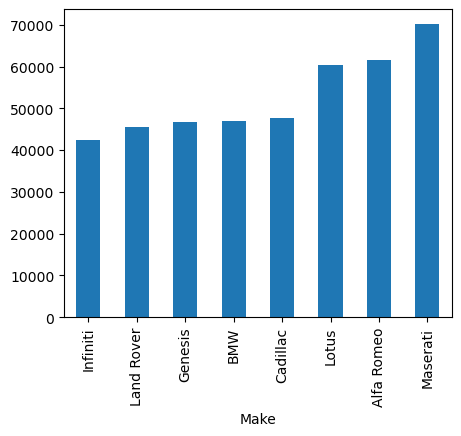

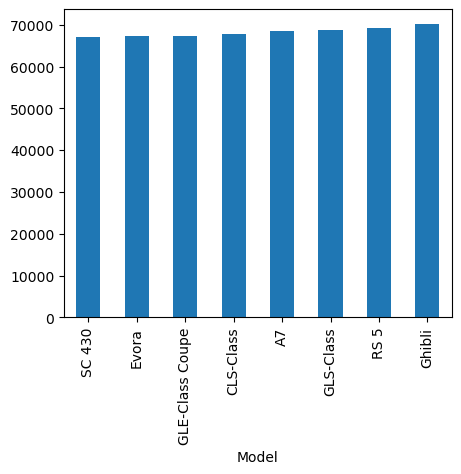

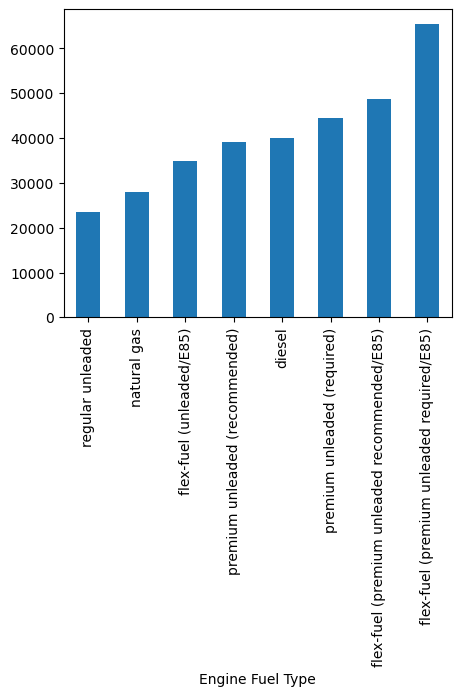

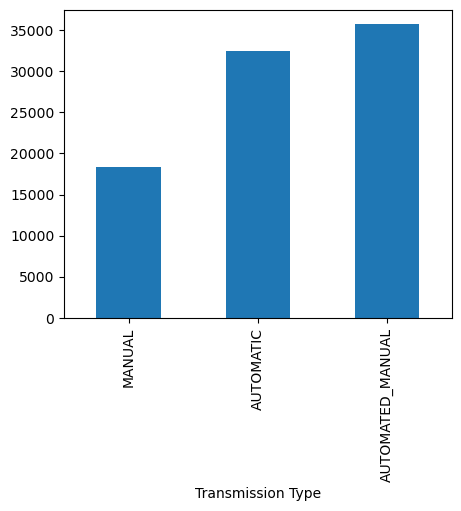

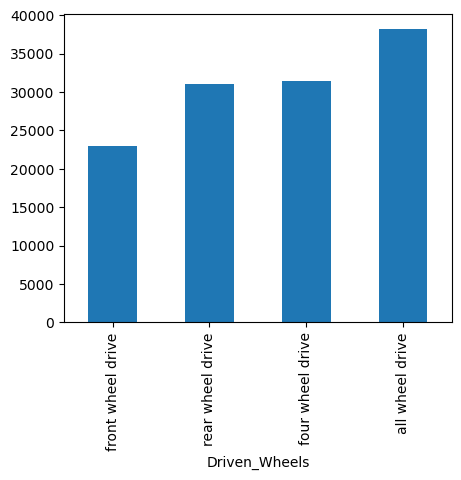

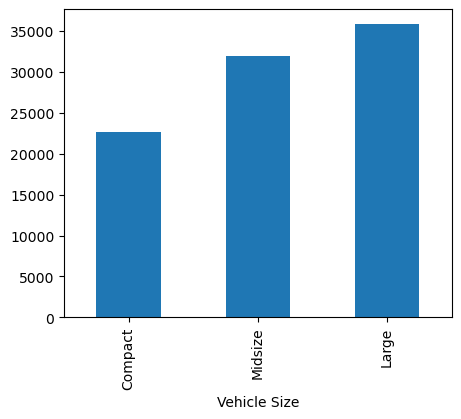

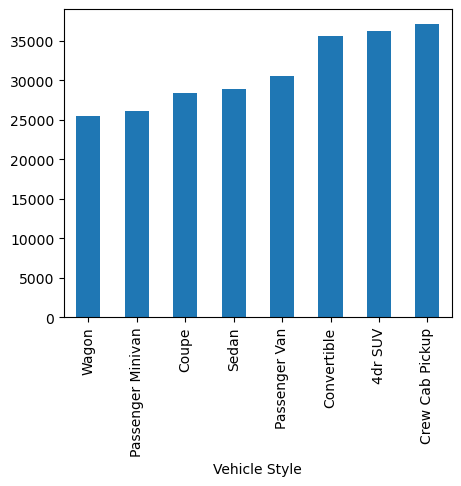

In [231]:
#categorical data extraction
cat_col = data.select_dtypes(exclude=[np.number])
#bar visualization
plt.rcParams['figure.figsize']=(5,4)
for index, key in enumerate(cat_col.keys()):
    i, j = divmod(index,2)
    y = data.groupby(key)['MSRP'].mean()
    y = y.sort_values()[-8:]
    y.plot.bar(x=key, y='MSRP', fontsize=10)

    plt.show()

In [234]:
cat_col = data.select_dtypes(exclude=[np.number])

len(cat_col.keys())
len(data.select_dtypes(include=[np.number]).keys())

8

분석결과

1. 각 회사별로 제품 가격 차이가 존재한다.
2. 더 좋은 연료를 사용할 수록 가격이 높다.
3. 기어는 자동일 수록 가격이 높다. auto maual은 쉬프트가 달린것
4. 바퀴는 동력원이 많을 수록 가격이 높다.
5. 차체가 클수록 가격이 높다.

<br>
<br>
자 이렇게 대략적인 EDA가 종료되었고, 이를 통해서 우리는 이제 인공지능을 학습해 볼 것이다.

## Preprocessing

인공지능에게 학습시키기에 앞서, 먼저 인공지능이 학습하기에 적합하도록 가공하는 과정을 거쳐야한다. 인공지능은 셀 수 없는 데이터를 이해하지 못하므로, 이를 Categorical Data로 변환하는 과정을 거쳐야 한다.

In [239]:
cat_features = data.select_dtypes(exclude=[np.number]).keys()

cat_data = pd.get_dummies(data, columns = cat_features)
cat_data.shape

(9757, 821)

In [243]:
#Splitting datset into train and test

X = cat_data.drop('MSRP', axis = 1)
y = cat_data['MSRP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, 
                                                   random_state = 42)
#startify를 안 한 이유: 특정 가격을 갖는 제품이 하나밖에 존재하지 않으면 오류가 발생


In [244]:
#Normalization
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Modeling

훈련 모델은 여러 레퍼런스에서 자주 쓰였던 RandomForestRegressor를 사용하자.

In [246]:
rfr = RandomForestRegressor(n_estimators=1000, max_leaf_nodes = 700, random_state = 42)

rfr.fit(X_train, y_train)

NameError: name 'x_test' is not defined

In [252]:
y_pred = rfr.predict(X_test)


print("MSE: ", mean_absolute_error(y_test, y_pred))



MSE:  2230.6104478390275


평균적으로 2000달러의 오차가 벌어지는 것으로 보아 학습이 성공적으로 된 것을 확인할 수 있다. 차의 가격 평균은 29176달러이다.

<AxesSubplot: xlabel='MSRP', ylabel='Predicted Value'>

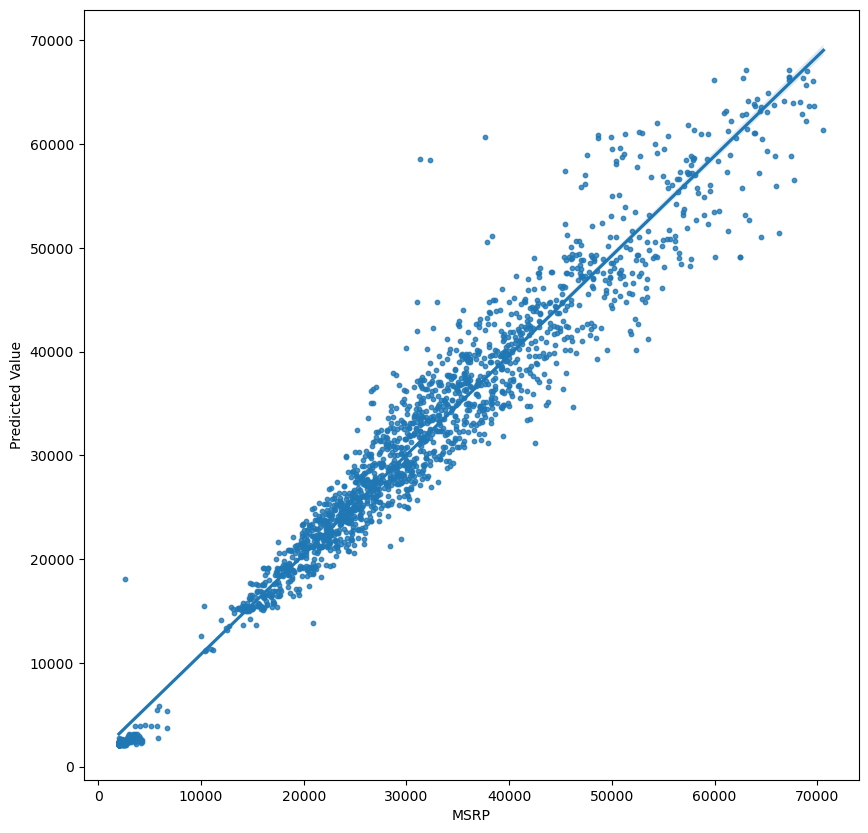

In [260]:
plt.figure(figsize=(10,10))
plt.ylabel("Predicted Value")
sns.regplot(x=y_test, y=y_pred, fit_reg=True, scatter_kws={"s": 10})

## Saving Model

In [265]:
import pickle

pickle.dump(rfr,open('C:/Users/Unity/RFR_Model.pkl','wb'))